In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import interact, fixed, FloatSlider, IntSlider

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
def get_dados(indice='portfolio'):
    if indice=='portfolio':
        df = pd.read_csv('dados/retorno_portfolio.csv', parse_dates=['Date'])
        df.fillna(0, inplace=True)
    if indice=='ACWI':    
        df = pd.read_csv('dados/retorno_portfolio.csv', parse_dates=['Date'])
        df.fillna(0, inplace=True)
        df['retorno'] = df['ACWI']
    else:
        url = f'https://query1.finance.yahoo.com/v7/finance/download/{indice}?period1=852076800&period2=1634743473&interval=1d&events=history&includeAdjustedClose=true'
        df = pd.read_csv(url)
        df['Date'] = pd.to_datetime(df['Date'])
        df['retorno'] = df['Close'].pct_change()
        
    df['year_week'] = df['Date'].dt.strftime('%Y-%U')
    df['retorno acumulado'] = df['retorno'] + 1
    df['retorno acumulado'] = df['retorno acumulado'].cumprod()
    
    df_gsrai = pd.read_csv('dados/GSRAII.csv', parse_dates=['Date']).sort_values('Date')

    df = df.merge(df_gsrai, on='Date')
    return df[['Date', 'retorno acumulado', 'GSRAII Index', 'year_week']].dropna()

### Indices:
- ^GSPC = *SP500*
- ^BVSP = *Bovespa*
- ACWI
- portfolio

In [8]:
# Trocar codigo do indice
indice='^GSPC'
df = get_dados(indice=indice)
df

,Date,retorno acumulado,GSRAII Index,year_week
1,1997-01-03,1.014952,0.13,1997-00
2,1997-01-06,1.014437,0.22,1997-01
3,1997-01-07,1.022008,0.21,1997-01
4,1997-01-08,1.015468,0.22,1997-01
5,1997-01-09,1.024206,0.18,1997-01
...,...,...,...,...
6160,2021-08-19,5.977938,-0.11,2021-33
6161,2021-08-20,6.026607,-0.09,2021-33
6162,2021-08-23,6.077977,-0.02,2021-34
6163,2021-08-24,6.087068,0.08,2021-34


In [9]:
#%% Semanal
df_gp = df.groupby('year_week').agg('last')

In [10]:
for pct in range(1,6):
    df_gp[f'pct_sem_0-{pct}'] = (df_gp['retorno acumulado']/df_gp['retorno acumulado'].shift(pct).values -1) * 100

In [11]:
def classe_gsrai(df, limit=0, media_movel=3):
    
    df=df.copy()
    df['mean'] = df['GSRAII Index'].rolling(media_movel).mean()
    up_down = df['mean']

    df['gsrai_gt_up'] = np.where((df['GSRAII Index'] > up_down) & (df['GSRAII Index'] >= limit), 1, 0)
    df['gsrai_gt_down'] = np.where((df['GSRAII Index'] < up_down) & (df['GSRAII Index'] >= limit), 1, 0)
    df['gsrai_lt_up'] = np.where((df['GSRAII Index'] > up_down) & (df['GSRAII Index'] < limit), 1, 0)
    df['gsrai_lt_down'] = np.where((df['GSRAII Index'] < up_down) & (df['GSRAII Index'] < limit), 1, 0)

    regras = ['gsrai_gt_up', 'gsrai_gt_down', 'gsrai_lt_up', 'gsrai_lt_down']
    df['classe'] = np.nan
    for col in regras:
        df.loc[df[col]==1, 'classe'] = col
    return df.dropna()

In [12]:
df_gp =  classe_gsrai(df=df_gp, limit=0, media_movel=3)

In [13]:
pct =  'pct_sem_0-3'
regras = ['gsrai_gt_up', 'gsrai_gt_down', 'gsrai_lt_up', 'gsrai_lt_down']

In [16]:
lista = []
for col in df_gp['classe'].unique():
    desc = df_gp[df_gp[col]==1][[pct]].describe().rename(columns={pct: col})
    lista.append(desc)
pd.concat(lista, axis=1)

,gsrai_gt_down,gsrai_gt_up,gsrai_lt_down,gsrai_lt_up
count,260.000000,377.000000,340.000000,313.000000
mean,0.731362,1.613290,-2.195612,1.863994
std,2.913398,2.499989,4.546833,4.560710
min,-8.351541,-7.144465,-28.353571,-22.478099
25%,-0.953529,0.237997,-4.049180,-0.309974
50%,0.830090,1.572469,-1.832571,2.010218
75%,2.463103,2.991507,0.526419,4.116662
max,10.210797,12.324682,7.693614,21.037614


In [17]:
@interact(df=fixed(df_gp), 
          pct=['pct_sem_0-1','pct_sem_0-2', 'pct_sem_0-3', 'pct_sem_0-4', 'pct_sem_0-5'],
          limit=FloatSlider(min=-1, max=1, step=0.05, value=0),
          media_movel=IntSlider(min=2, max=6, step=1, value=3)
         )
def hist_classes(df, pct, limit=0, media_movel=3):
    df = classe_gsrai(df=df, limit=limit, media_movel=media_movel)
    fig = px.histogram(df, x=pct, color="classe", marginal="box", nbins=100, 
#                        range_y=[0,50],
                       range_x=[df[pct].min()-1,df[pct].max()+1],
                       title=f'Distribuição {indice} {pct} ',
                      )
    fig.update_layout(barmode='overlay')
    fig.update_traces(opacity=0.65)
    fig.add_vline(x=0,line_dash="dash")
    
    for i, classe in enumerate(df['classe'].unique()):
        fig.add_annotation(text=f'Total {classe}: {len(df[df["classe"]==classe])} ',
                           showarrow=False, yshift=70-(i*19), xshift=450)
        fig.add_annotation(text=f'σ {classe}: {df[df["classe"]==classe][pct].std():.2f} ',
                           showarrow=False, yshift=200-(i*19), xshift=450)
    
    return fig

    
hist_classes(df_gp, pct, limit=-1, media_movel=3);

interactive(children=(Dropdown(description='pct', options=('pct_sem_0-1', 'pct_sem_0-2', 'pct_sem_0-3', 'pct_s…

In [18]:
cut = df_gp[pct].quantile(0.05)
df_gp[(df_gp['pct_sem_0-3']<=cut)].sum()

retorno acumulado                                           115.481865
GSRAII Index                                                    -75.86
pct_sem_0-1                                                -245.670018
pct_sem_0-2                                                -448.857488
pct_sem_0-3                                                -646.903074
pct_sem_0-4                                                -668.691012
pct_sem_0-5                                                 -694.67417
mean                                                        -61.186667
gsrai_gt_up                                                          2
gsrai_gt_down                                                        5
gsrai_lt_up                                                         12
gsrai_lt_down                                                       46
classe               gsrai_lt_downgsrai_lt_downgsrai_lt_downgsrai_l...
dtype: object

In [19]:
df_gp[(df_gp['pct_sem_0-3']>cut) & (df_gp['gsrai_lt_down']==1)][pct].describe()

count    294.000000
mean      -0.919190
std        2.863666
min       -6.048450
25%       -3.152576
50%       -1.066665
75%        1.038444
max        7.693614
Name: pct_sem_0-3, dtype: float64

<AxesSubplot:>

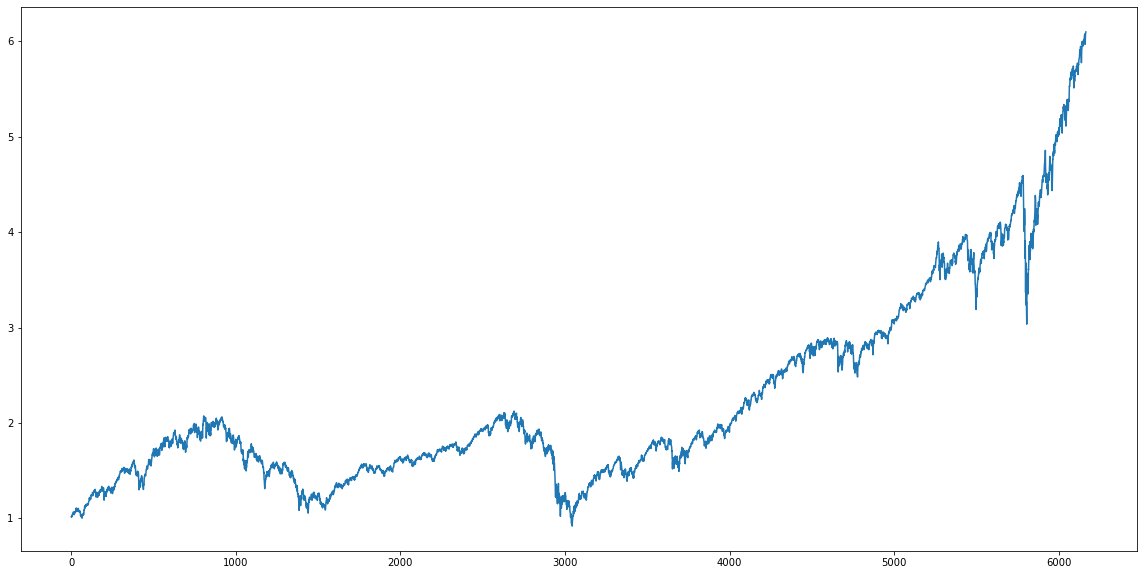

In [20]:
df['retorno acumulado'].plot(x = 'Date', figsize=(20,10))